In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from keras.datasets import mnist
import seaborn as sns
import pandas as pd
import sys
from tqdm import tqdm

from barebones_ai.supervised.nn import DNN
from barebones_ai.supervised.nn import SGD
from barebones_ai.supervised.nn import Dense
from barebones_ai.supervised.nn import Input
from barebones_ai.supervised.nn import Softmax
from barebones_ai import utils

import copy

%matplotlib inline

/home/shyam/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-02-19 16:39:46.060457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 16:39:46.681602: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shyam/.mujoco/mujoco210/bin:/usr/lib/nvidia:/home/shyam/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-02-19 16:39:46.681654: W 

# AutoEncoder Example using DNN

## Demonstrated using mnist data

In [2]:
(X_train_digits, y_train), (X_test_digits, y_test) = mnist.load_data()

In [3]:
X_train = np.array(list(map(lambda x: x.flatten()/255,X_train_digits)))
X_test = np.array(list(map(lambda x: x.flatten()/255,X_test_digits)))

In [4]:
class AutoEncoder():
    """
    An auto encoder is a semi supervised learning algorithm that attempts to reconstruct input using a smaller feature space
    Parameters:
        X: numpy array(): data matrix
        encoder: DNN to reduce dimensions of matrix
        decoder: DNN to recreate the original data from the encoded data
        full_model: DNN that combines both the encoder and decoder objects, used to train both
    """
    def __init__(self,X):
        
        self.X = X
        self.encoder = None
        self.decoder = None
        self.full_model = DNN()
        self.full_model.add(Input(X))
        self.count = 0
        
    def create_encoder(self,layers=[Dense(32),Dense(512)],encoded_dims=2):
        
        self.count = 0
        for layer in layers:
            self.full_model.add(layer)
            self.count += 1
            
        self.full_model.add(Dense(encoded_dims))
        
    def create_decoder(self,layers=[Dense(32)]):
        
        if len(layers) > 0:
            for layer in layers:
                self.full_model.add(layer)
            
        self.full_model.add(Dense(self.X.shape[-1]))
    
    def finalize_encoder_decoder(self):
        
        count = 0
        layer = self.full_model.head.getNext()
        self.encoder = DNN()
        self.decoder = DNN()
        self.encoder.add(Input(self.X))
        
        while layer != None:
            print(layer)
            newlay = copy.deepcopy(layer)
            if count <= self.count:
                self.encoder.add(newlay)
                self.encoder.outlayer.update(newlay.getWeights())
                if count == a.count:
                    self.encoder.outlayer.next = None
                    self.decoder.add(Input(self.encoder.outlayer.output))

            else:
                self.decoder.add(newlay)
                self.decoder.outlayer.update(newlay.getWeights())
            layer = layer.getNext()
            count += 1
            
    def train(self,learning_rate=0.0001,epochs=100,loss="mse"):
        
        self.full_model.fit(self.X,self.X,lr=learning_rate,epochs=epochs,loss=loss)
        self.finalize_encoder_decoder()
    
    def predict(self,X):
        
        encoded = self.encoder.predict(X)
        decoded = self.decoder.predict(encoded)
        return encoded,decoded, self.full_model.predict(X)


In [5]:
a = AutoEncoder(X_train[:200])
a.create_encoder()
a.create_decoder()

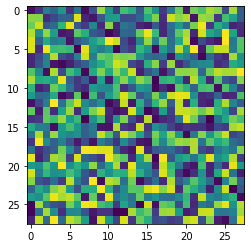

In [6]:
prediction = a.full_model.predict(X_train[0].reshape(1,784)).reshape(28,28)
plt.imshow(prediction)

In [7]:
a.train(epochs=500,learning_rate=0.004,loss="mse")

MSE 0.06429422548351559: 100%|█████████████████████████████████████████| 500/500 [01:53<00:00,  4.40it/s]

Dense: activation: sigmoid, weight shape: (784, 32), output shape: (None, 32), parameters: 25088
-----------------------------------------------------------------

Dense: activation: sigmoid, weight shape: (32, 512), output shape: (None, 512), parameters: 16384
-----------------------------------------------------------------

Dense: activation: sigmoid, weight shape: (512, 2), output shape: (None, 2), parameters: 1024
-----------------------------------------------------------------

Dense: activation: sigmoid, weight shape: (2, 32), output shape: (None, 32), parameters: 64
-----------------------------------------------------------------

Dense: activation: sigmoid, weight shape: (32, 784), output shape: (None, 784), parameters: 25088
-----------------------------------------------------------------



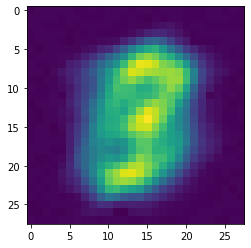

In [8]:
plt.imshow(a.predict(X_train[0])[2].reshape(28,28))

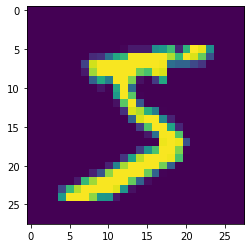

In [9]:
plt.imshow(X_train[0].reshape(28,28))